In [1]:
# Uninstall everything
# !pip uninstall tensorflow tensorflow-gpu keras
# Reinstall
# !pip install tensorflow==2.15

In [1]:
import tensorflow as tf
import os
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from IPython.display import display, Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras_tuner as kt
import torch

2025-07-10 19:45:56.238273: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-10 19:45:56.267984: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-07-10 19:45:56.968241: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Configure GPU memory growth
def configure_gpu_for_large_dataset():
    """Optimize GPU settings for large datasets"""
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Enable memory growth instead of allocating all GPU memory
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            
            # Optional: Set memory limit if needed
            # tf.config.experimental.set_memory_limit(gpus[0], 3584)  # 3.5GB limit
            
            print("✅ GPU memory growth enabled")
        except RuntimeError as e:
            print(f"GPU configuration error: {e}")

# Call this before training
configure_gpu_for_large_dataset()

✅ GPU memory growth enabled


2025-07-10 19:46:00.194188: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-10 19:46:00.266368: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-10 19:46:00.282833: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [3]:

# Clear TensorFlow state before rerunning
# tf.keras.backend.clear_session()

# Reset GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print("TensorFlow version:", tf.__version__)
        print("GPU devices:", tf.config.list_physical_devices('GPU'))
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(f"GPU setup warning: {e}")

# Set environment variables
# os.environ['XLA_FLAGS'] = '--xla_gpu_cuda_data_dir=/home/monkey/miniconda/envs/tf-gpu'
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


TensorFlow version: 2.13.0
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print("GPU","available (YESSSS!!!!)" if tf.config.list_physical_devices('GPU') else "No GPU available")

GPU available (YESSSS!!!!)


In [5]:
labels_csv = pd.read_csv('./labels.csv')
labels_csv.describe()

id               breed
count                              10222               10222
unique                             10222                 120
top     000bec180eb18c7604dcecc8fe0dba07  scottish_deerhound
freq                                   1                 126

In [6]:
labels_csv.head(10)

id               breed
0  000bec180eb18c7604dcecc8fe0dba07         boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97               dingo
2  001cdf01b096e06d78e9e5112d419397            pekinese
3  00214f311d5d2247d5dfe4fe24b2303d            bluetick
4  0021f9ceb3235effd7fcde7f7538ed62    golden_retriever
5  002211c81b498ef88e1b40b9abf84e1d  bedlington_terrier
6  00290d3e1fdd27226ba27a8ce248ce85  bedlington_terrier
7  002a283a315af96eaea0e28e7163b21b              borzoi
8  003df8b8a8b05244b1d920bb6cf451f9             basenji
9  0042188c895a2f14ef64a918ed9c7b64  scottish_deerhound

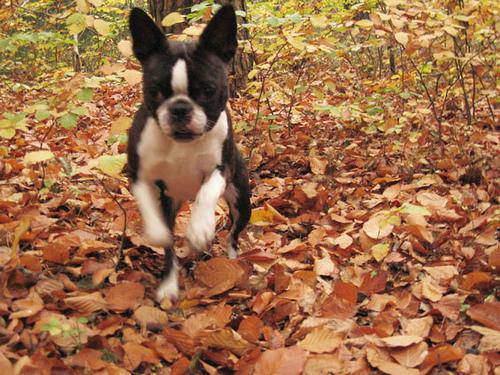

In [7]:
display(Image(filename='./train/000bec180eb18c7604dcecc8fe0dba07.jpg'))

In [8]:
images = [ './train/'+name+'.jpg' for name in labels_csv['id']]

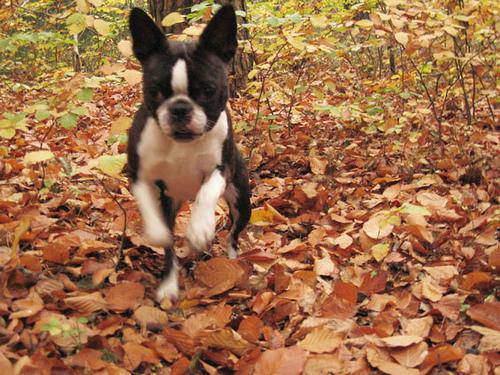

In [9]:
display(Image(filename=images[0]))

In [10]:
# prepping y values to test

labels = labels_csv['breed'].to_numpy()
len(labels)

10222

In [11]:
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [12]:
boolean_labels = [ unique_breeds == name for name in labels]
boolean_labels[:2]

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

bedlington_terrier
(array([10]),)
['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_sp

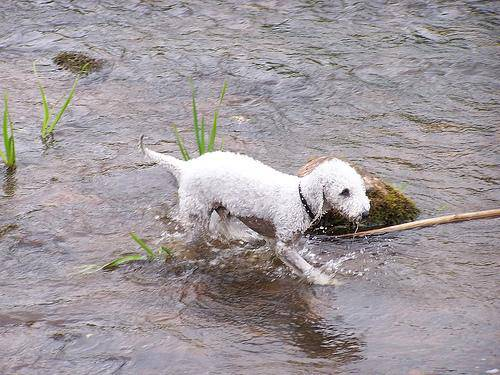

In [13]:
index = 5
print(labels[index])
print(np.where(unique_breeds==labels[index]))
print(unique_breeds)
print(boolean_labels[index].argmax())
print(boolean_labels[index].astype(int))
display(Image(filename=images[index]))

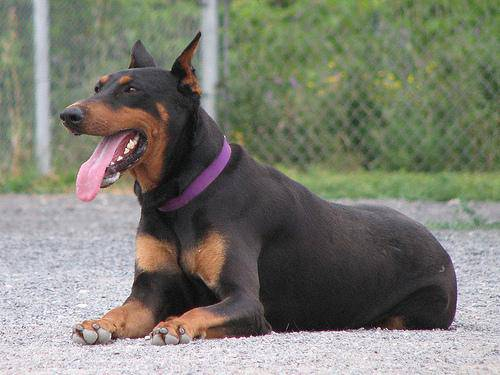

In [14]:
display(Image(filename=images[20]))

In [15]:
Image_Quota = 10000
X = images
y = boolean_labels

In [16]:
X_train, X_val, y_train, y_val = train_test_split(X[:Image_Quota],y[:Image_Quota], test_size=0.2, random_state=42)
len(X_train), len(X_val), len(y_train), len(y_val)

(8000, 2000, 8000, 2000)

pomeranian


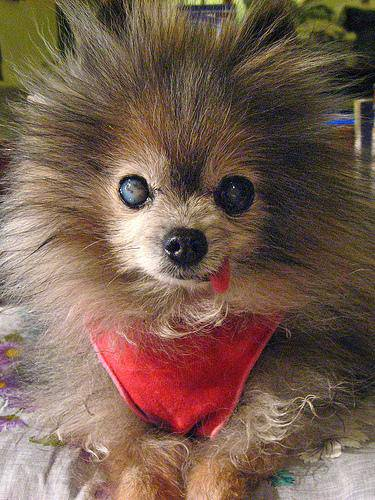

In [17]:
index = 250
print(unique_breeds[y_train[index].argmax()])

# print(unique_breeds)
# print(boolean_labels[index].argmax())
# print(boolean_labels[index].astype(int))
display(Image(filename=X_train[index]))

gordon_setter


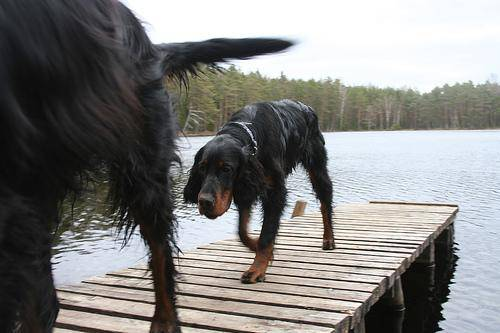

In [18]:
index = 25
print(unique_breeds[y_val[index].argmax()])

# print(unique_breeds)
# print(boolean_labels[index].argmax())
# print(boolean_labels[index].astype(int))
display(Image(filename=X_val[index]))

In [19]:
# image size ( resize the image into (224,224) shape)
IMG_SIZE = 224
BATCH_SIZE =16

In [20]:
# accept image path and convert into tensor
def preprocess_image(img_path,img_size=IMG_SIZE):
  image = tf.io.read_file(img_path) # rf
  # turn image into numerical tensor with 3 color channels (Red, Green, Blue)
  image = tf.image.decode_jpeg(image,channels=3) # djpeg
  # convert color channels from 0-255 to 0-1 (normalization)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cid
  # image resize to (244,244)
  image = tf.image.resize(image, size= [IMG_SIZE,IMG_SIZE])
  return image


In [21]:
def create_data_batches( X, y=None, batch_size=BATCH_SIZE, valid_data= False, test_data= False):
  """
  creates batches of data:
  1. shuffles data if its test data
  2. accepts test data w/o input  (no labels)
  """
  if test_data:
    print('creating test data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X)))
    data_batch = data.map(preprocess_image).batch(BATCH_SIZE)
    return data_batch
  elif valid_data:
    print('creating valid data batches...')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data_batch = data.map(get_image_label).batch(BATCH_SIZE) 
    return data_batch
  else:
    print('creating train_data')
    data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y)))
    data = data.shuffle(buffer_size=len(X))
    data = data.map(get_image_label)
    data_batch = data.batch(BATCH_SIZE)
    return data_batch

## In order to use tensorflow effectively, we want our data to be in this form of tensor tuple: (image,label)

In [22]:
def get_image_label(image_path, label):
  image = preprocess_image(image_path)
  return image,label

In [23]:
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_val,y_val,valid_data=True)

creating train_data
creating valid data batches...


2025-07-09 13:32:01.204073: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 13:32:01.207050: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-07-09 13:32:01.209052: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [24]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 120), dtype=tf.bool, name=None)))

Before we build a model, there are few things we will have to check:
* The input shape (in form of tensors) to the model.
* The output shape (image labels, in the form of tensors) of our model
* The URL of model we are gonna use

In [25]:
INPUT_SHAPE = [None,IMG_SIZE,IMG_SIZE, 3]
OUTPUT_SHAPE = len(unique_breeds)
MODEL_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4'
print(INPUT_SHAPE,OUTPUT_SHAPE)

[None, 224, 224, 3] 120


1. Take input shape, output shape, and the model we have choosen as parameters
2. Define the layers in a keras model in sequential fashion

In [26]:

def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE,model_url=MODEL_URL):
    model = tf.keras.Sequential([
        hub.KerasLayer(model_url), 
        tf.keras.layers.Dense( units=OUTPUT_SHAPE, activation='softmax')
    ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',  # or 'sparse_categorical_crossentropy'
        metrics=['accuracy']
    )
    
    model.build(INPUT_SHAPE)
    return model

In [40]:
model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 120)               153720    
                                                                 
Total params: 2411704 (9.20 MB)
Trainable params: 153720 (600.47 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [41]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [42]:
import datetime
import os
# creating a function with tensorboard to log stories of learning
def creating_tensorboard_callback():
    logs_dir = os.path.join('./logs')
    return tf.keras.callbacks.TensorBoard(logs_dir)

In [43]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',patience=3)

In [44]:
import ipywidgets as widgets
from IPython.display import display

NUM_EPOCHS = widgets.IntSlider(
    value=10,
    min=10,
    max=100,
    step=10,  
    readout_format='d'
)
display(NUM_EPOCHS)

IntSlider(value=10, min=10, step=10)

In [47]:
NUM_EPOCHS.value

90

In [6]:
print("GPU","available (YESSSS!!!!)" if tf.config.list_physical_devices('GPU') else "No GPU available")

GPU No GPU available


In [49]:
def train_model():
    model = create_model()
    tensorboard = creating_tensorboard_callback()
    model.fit(
        x =train_data,
        epochs=NUM_EPOCHS.value,
        validation_data=valid_data,
        validation_freq=1,
        callbacks=[tensorboard,early_stopping]     ,
    )
    return model

In [50]:
model = train_model()

Epoch 1/90


2025-07-05 10:24:35.685395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-07-05 10:24:37.352273: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x5b836ad64a60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-07-05 10:24:37.352294: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-07-05 10:24:37.368935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-07-05 10:24:37.491545: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 [==============================] - 6s 114ms/step - loss: 4.3201 - accuracy: 0.1200 - val_loss: 3.2747 - val_accuracy: 0.3150
Epoch 2/90
25/25 [==============================] - 2s 81ms/step - loss: 1.7608 - accuracy: 0.7188 - val_loss: 2.0614 - val_accuracy: 0.5700
Epoch 3/90
25/25 [==============================] - 2s 81ms/step - loss: 0.7380 - accuracy: 0.9275 - val_loss: 1.6227 - val_accuracy: 0.6700
Epoch 4/90
25/25 [==============================] - 2s 81ms/step - loss: 0.3819 - accuracy: 0.9825 - val_loss: 1.4115 - val_accuracy: 0.7000
Epoch 5/90
25/25 [==============================] - 2s 81ms/step - loss: 0.2402 - accuracy: 0.9937 - val_loss: 1.3222 - val_accuracy: 0.7100
Epoch 6/90
25/25 [==============================] - 2s 80ms/step - loss: 0.1674 - accuracy: 0.9962 - val_loss: 1.2733 - val_accuracy: 0.7200
Epoch 7/90
25/25 [==============================] - 2s 82ms/step - loss: 0.1269 - accuracy: 0.9987 - val_loss: 1.2471 - val_accuracy: 0.7350
Epoch 8/90
25/25 [=====

In [54]:
model.save('./models/ImageClassification')

INFO:tensorflow:Assets written to: ./models/ImageClassification/assets


INFO:tensorflow:Assets written to: ./models/ImageClassification/assets


In [52]:
loaded_model = tf.keras.models.load_model('./models/ImageClassification')

In [51]:
#!pip3 install oauthlib

In [52]:
%load_ext tensorboard
%tensorboard --logdir ./logs/validation --port 9000

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 9000 (pid 6999), started 1:49:14 ago. (Use '!kill 6999' to kill it.)

## creating prediction out of our model

In [53]:
y_predict = loaded_model.predict(valid_data)

2025-07-05 13:13:23.247819: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907


7/7 [==============================] - 5s 287ms/step


In [ ]:
def get_result_data(batched_dataset):
    unbatched_data = batched_dataset.unbatch()
    for image,label in valid_data.unbatch().as_numpy_iterator():
        dog_name = unique_breeds[label.argmax()]

In [24]:
image_iterator = valid_data.unbatch().as_numpy_iterator()

In [27]:
def prob_to_255_simple(prob_image):
    """
    Convert probability image (0-1) to 0-255 range
    Simple method: multiply by 255 and convert to uint8
    """
    # Ensure values are in [0, 1] range
    prob_image = np.clip(prob_image, 0, 1)
    
    # Convert to 0-255 range
    image_255 = (prob_image * 255).astype(np.uint8)
    
    return image_255

In [125]:
y_predict[0][y_predict[0].argsort()[-10:][::-1]]

array([0.20839444, 0.13766083, 0.09864319, 0.07450438, 0.07316456,
       0.05389185, 0.04678502, 0.04478849, 0.04298308, 0.04120813],
      dtype=float32)

In [56]:
def get_image_from_boolean_unique(bool_breed):
    return unique_breeds[bool_breed.argmax()]

In [130]:
def get_ten_most_probable_names(predictions):
    return unique_breeds[predictions.argsort()[-10:][::-1]]

In [131]:
def show_result(image,predicted_dog_name,label,probableValue):
    # plt.figsize(figsize=(10,10))
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    color = 'red'
    if predicted_dog_name == label: color = 'green'
    plt.title(f"{predicted_dog_name} {probableValue*100:.2f} {label}",color=color)
    plt.show()
    


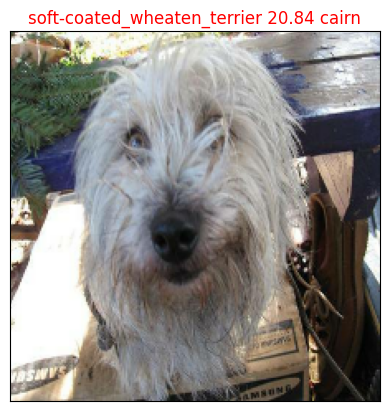

below can be your dogs as well:
['soft-coated_wheaten_terrier' 'maltese_dog' 'lhasa' 'cairn'
 'border_terrier' 'norfolk_terrier' 'tibetan_terrier' 'irish_wolfhound'
 'west_highland_white_terrier' 'australian_terrier']


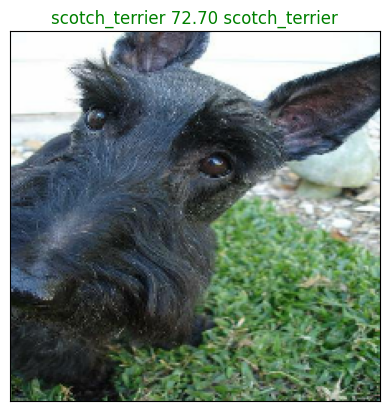

below can be your dogs as well:
['scotch_terrier' 'mexican_hairless' 'scottish_deerhound'
 'irish_wolfhound' 'standard_schnauzer' 'irish_terrier' 'giant_schnauzer'
 'miniature_schnauzer' 'afghan_hound' 'groenendael']


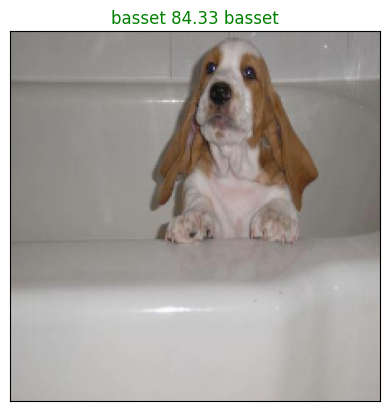

below can be your dogs as well:
['basset' 'welsh_springer_spaniel' 'blenheim_spaniel' 'english_foxhound'
 'beagle' 'basenji' 'walker_hound' 'golden_retriever' 'yorkshire_terrier'
 'brittany_spaniel']


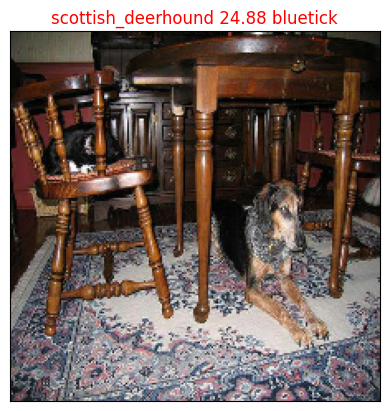

below can be your dogs as well:
['scottish_deerhound' 'lakeland_terrier' 'border_terrier'
 'yorkshire_terrier' 'standard_schnauzer' 'saluki' 'miniature_schnauzer'
 'irish_terrier' 'chesapeake_bay_retriever' 'wire-haired_fox_terrier']


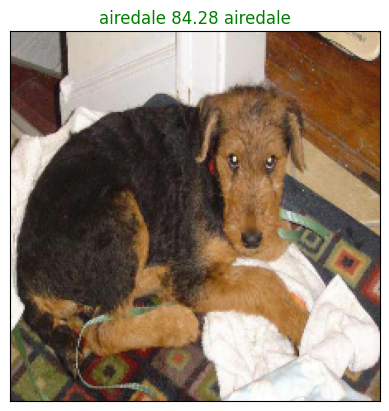

below can be your dogs as well:
['airedale' 'irish_terrier' 'lakeland_terrier' 'wire-haired_fox_terrier'
 'yorkshire_terrier' 'appenzeller' 'border_terrier' 'irish_wolfhound'
 'redbone' 'chesapeake_bay_retriever']


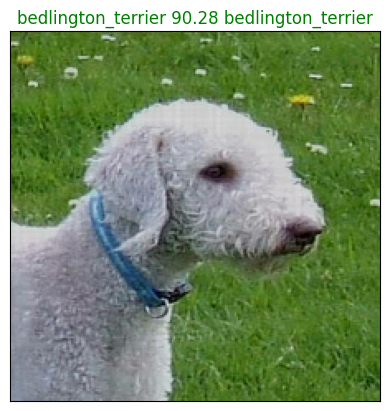

below can be your dogs as well:
['bedlington_terrier' 'kuvasz' 'miniature_poodle' 'lakeland_terrier'
 'airedale' 'curly-coated_retriever' 'wire-haired_fox_terrier'
 'irish_wolfhound' 'toy_poodle' 'bluetick']


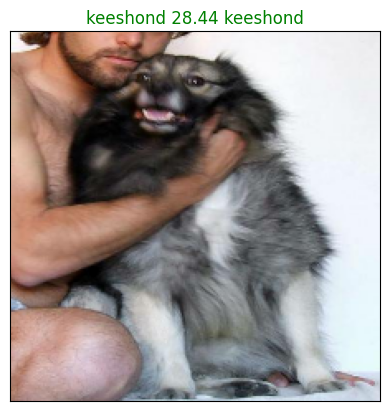

below can be your dogs as well:
['keeshond' 'norwegian_elkhound' 'malamute' 'collie' 'japanese_spaniel'
 'tibetan_mastiff' 'scottish_deerhound' 'irish_wolfhound'
 'miniature_schnauzer' 'brabancon_griffon']


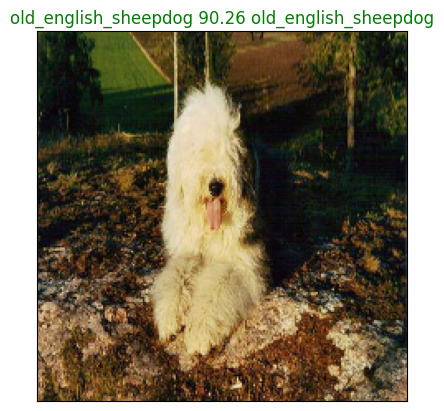

below can be your dogs as well:
['old_english_sheepdog' 'komondor' 'tibetan_terrier'
 'soft-coated_wheaten_terrier' 'great_pyrenees' 'lhasa' 'clumber'
 'otterhound' 'lakeland_terrier' 'irish_wolfhound']


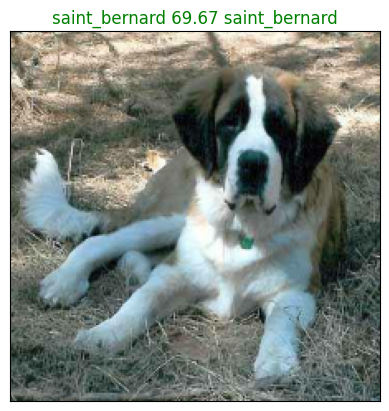

below can be your dogs as well:
['saint_bernard' 'blenheim_spaniel' 'brittany_spaniel' 'leonberg'
 'japanese_spaniel' 'tibetan_terrier' 'greater_swiss_mountain_dog' 'boxer'
 'bernese_mountain_dog' 'cocker_spaniel']


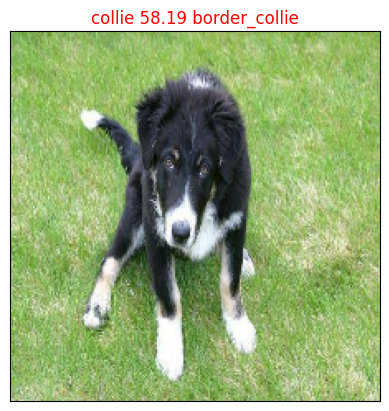

below can be your dogs as well:
['collie' 'border_collie' 'tibetan_mastiff' 'groenendael'
 'bernese_mountain_dog' 'scottish_deerhound' 'flat-coated_retriever'
 'malamute' 'kuvasz' 'schipperke']


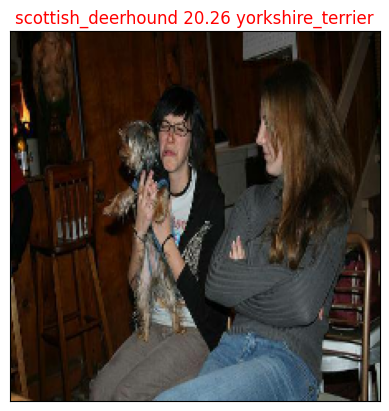

below can be your dogs as well:
['scottish_deerhound' 'miniature_schnauzer' 'shih-tzu' 'yorkshire_terrier'
 'irish_terrier' 'tibetan_terrier' 'irish_wolfhound' 'afghan_hound'
 'scotch_terrier' 'lhasa']


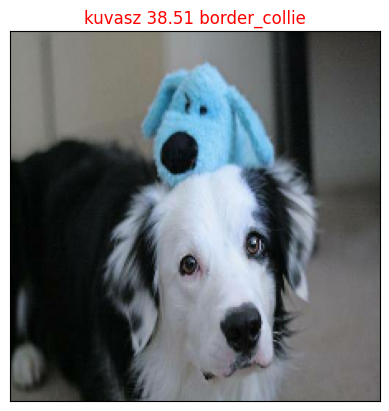

below can be your dogs as well:
['kuvasz' 'border_collie' 'great_pyrenees' 'collie' 'golden_retriever'
 'bernese_mountain_dog' 'saint_bernard' 'english_setter' 'samoyed'
 'maltese_dog']


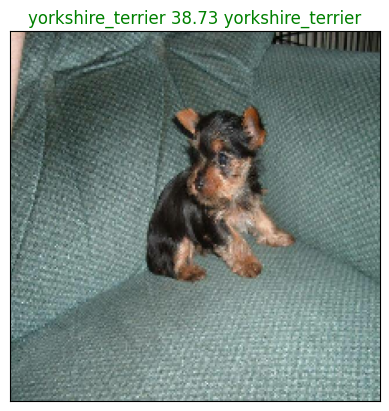

below can be your dogs as well:
['yorkshire_terrier' 'silky_terrier' 'australian_terrier'
 'miniature_pinscher' 'miniature_schnauzer' 'irish_terrier' 'papillon'
 'norfolk_terrier' 'affenpinscher' 'airedale']


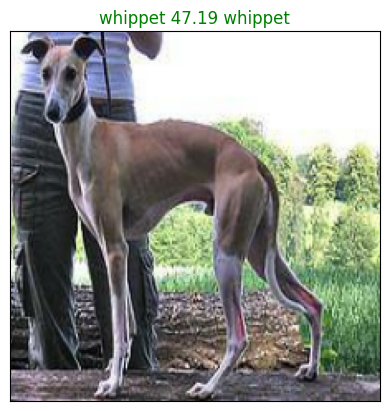

below can be your dogs as well:
['whippet' 'italian_greyhound' 'saluki' 'ibizan_hound' 'english_foxhound'
 'scottish_deerhound' 'basenji' 'vizsla' 'walker_hound' 'mexican_hairless']


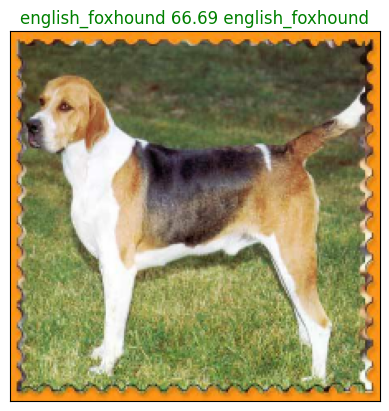

below can be your dogs as well:
['english_foxhound' 'walker_hound' 'beagle' 'basset' 'blenheim_spaniel'
 'brittany_spaniel' 'wire-haired_fox_terrier' 'basenji'
 'welsh_springer_spaniel' 'otterhound']


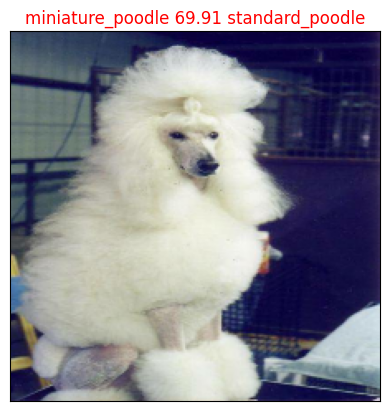

below can be your dogs as well:
['miniature_poodle' 'toy_poodle' 'standard_poodle' 'samoyed'
 'afghan_hound' 'great_pyrenees' 'chow' 'komondor' 'newfoundland'
 'old_english_sheepdog']


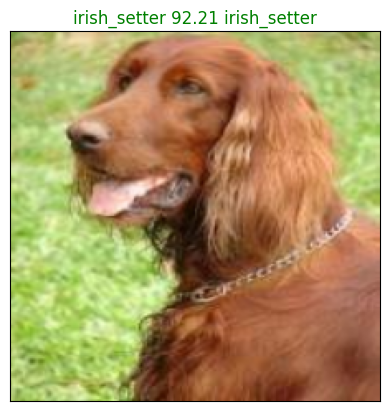

below can be your dogs as well:
['irish_setter' 'sussex_spaniel' 'cocker_spaniel' 'welsh_springer_spaniel'
 'gordon_setter' 'english_setter' 'redbone' 'vizsla'
 'chesapeake_bay_retriever' 'black-and-tan_coonhound']


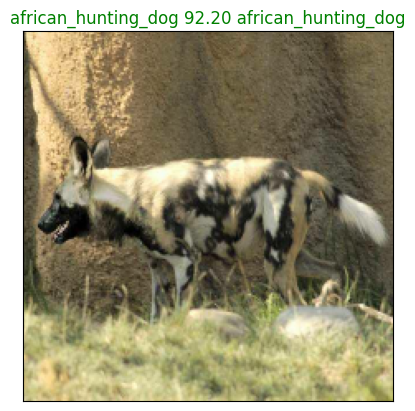

below can be your dogs as well:
['african_hunting_dog' 'cardigan' 'dhole' 'kuvasz' 'shih-tzu' 'collie'
 'irish_wolfhound' 'boston_bull' 'french_bulldog' 'dingo']


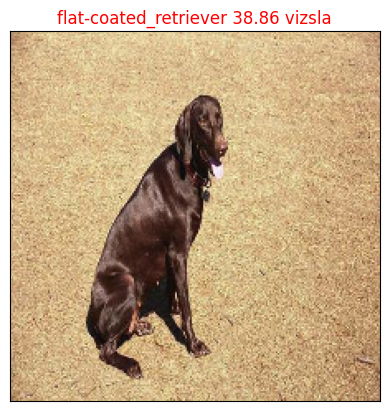

below can be your dogs as well:
['flat-coated_retriever' 'labrador_retriever'
 'german_short-haired_pointer' 'schipperke' 'chesapeake_bay_retriever'
 'irish_setter' 'black-and-tan_coonhound' 'chihuahua' 'groenendael'
 'tibetan_mastiff']


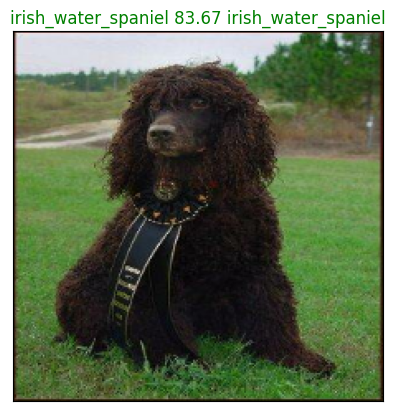

below can be your dogs as well:
['irish_water_spaniel' 'miniature_poodle' 'newfoundland'
 'curly-coated_retriever' 'afghan_hound' 'toy_poodle' 'standard_poodle'
 'cocker_spaniel' 'german_short-haired_pointer' 'chesapeake_bay_retriever']


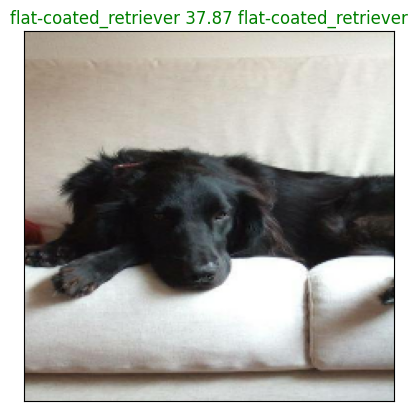

below can be your dogs as well:
['flat-coated_retriever' 'tibetan_mastiff' 'groenendael' 'gordon_setter'
 'golden_retriever' 'irish_setter' 'english_setter' 'schipperke' 'saluki'
 'cocker_spaniel']


In [135]:
index=0
# fig,axes = plt.subplots(11,1)

for image,label in valid_data.unbatch().as_numpy_iterator():
    image_255 = prob_to_255_simple(image)
    dog_name = unique_breeds[y_predict[index].argmax()]
    probableValue = y_predict[index].max()
    label = get_image_from_boolean_unique(label)
    if index>20: break
    show_result(image_255,dog_name,label,probableValue)
    print('below can be your dogs as well:')
    print(get_ten_most_probable_names(y_predict[index]))
    index += 1

# plt.tight_layout()
# plt.show()

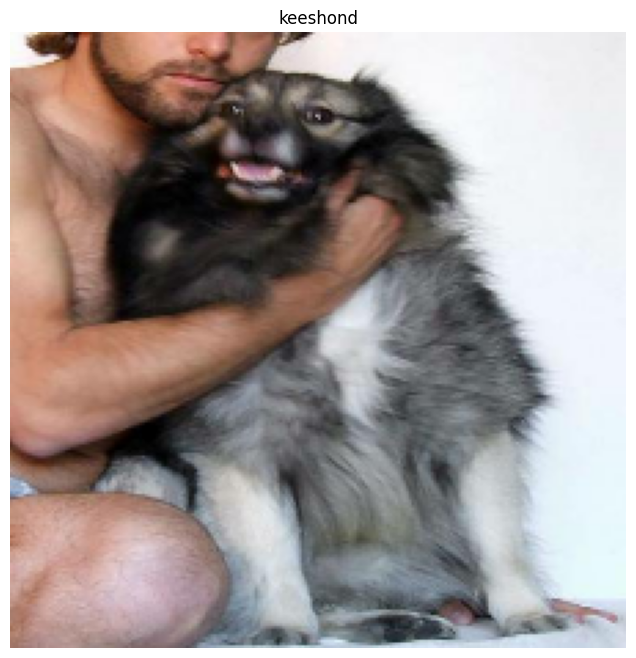

In [33]:

fig,axes = plt.subplots(figsize=(12,8))
image,label = next(image_iterator)
image_255 = prob_to_255_simple(image)
dog_name = unique_breeds[label.argmax()]
axes.imshow(image_255)
axes.set_title(dog_name)
axes.axis('off')
plt.show()

## Experimentation: Hyperparameter tuning

In [2]:
# import sys
# !{sys.executable} -m pip install keras-tuner

/bin/bash: /home/monkey/miniconda/envs/tf-gpu/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Defaulting to user installation because normal site-packages is not writeable
  Using cached keras_tuner-1.4.7-py3-none-any.whl.metadata (5.4 kB)
  Using cached kt_legacy-1.0.5-py3-none-any.whl.metadata (221 bytes)
Using cached keras_tuner-1.4.7-py3-none-any.whl (129 kB)
Using cached kt_legacy-1.0.5-py3-none-any.whl (9.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [keras-tuner]


In [25]:
import keras_tuner as kt
kt.__version__

'1.4.7'

In [34]:
# Put this at the top of your script
# import os
# import tensorflow as tf

# # Configure environment before importing other modules
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Reduce log noise
# os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices=false'

# # Alternative: Try different CUDA paths
# cuda_paths = [
#     '/home/monkey/miniconda/envs/tf-gpu/lib',
#     '/home/monkey/miniconda/envs/tf-gpu',
#     '/usr/local/cuda-11.8',
#     '/usr/local/cuda'
# ]

# for path in cuda_paths:
#     if os.path.exists(path):
#         os.environ['XLA_FLAGS'] = f'--xla_gpu_cuda_data_dir={path}'
#         print(f"Set CUDA path to: {path}")
#         break

# # Verify GPU is still available
# print("GPU devices:", tf.config.list_physical_devices('GPU'))
# print("CUDA built:", tf.test.is_built_with_cuda())

# Continue with your keras tuner code...

Set CUDA path to: /home/monkey/miniconda/envs/tf-gpu/lib
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
CUDA built: True


In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Wait 8 epochs for improvement
    restore_best_weights=True,
    verbose=1
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

In [30]:
# import keras_tuner as kt
# # Clear TensorFlow state before rerunning
# tf.keras.backend.clear_session()

# # Reset GPU memory growth
# gpus = tf.config.list_physical_devices('GPU')
# if gpus:
#     try:
#         print("TensorFlow version:", tf.__version__)
#         print("GPU devices:", tf.config.list_physical_devices('GPU'))
#         for gpu in gpus:
#             tf.config.experimental.set_memory_growth(gpu, True)
#     except RuntimeError as e:
#         print(f"GPU setup warning: {e}")
        
def build_model(hp):
    model = tf.keras.Sequential([
        hub.KerasLayer(MODEL_URL),
        tf.keras.layers.Dense(
            units=hp.Int('dense_units',min_value=64,max_value=1028,step=32),
            activation='relu'
        ),
        tf.keras.layers.Dropout(hp.Float('dropout',0.1,0.5,step=0.1)),
        tf.keras.layers.Dense(units=OUTPUT_SHAPE,activation='softmax'),
    ])
    model.compile(
        optimizer=hp.Choice('optimizer',['adam','rmsprop','sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    directory='./models/experiment_image_classifier_1'
)

tuner.search(train_data,epochs=60,validation_data=valid_data,callbacks=[early_stopping, reduce_lr])

best_models = tuner.get_best_models()





Trial 5 Complete [00h 00m 46s]
val_accuracy: 0.7250000238418579

Best val_accuracy So Far: 0.7350000143051147
Total elapsed time: 00h 07m 36s
